In [ ]:
import os
import sys 
from pathlib import Path

# Dynamically locate project root and set working dir
# Go up 2 levels from notebook location: notebooks -> app-ml -> ml-project
current_dir = Path().resolve()
project_root = current_dir.parent.parent

# Verify we're in the right place (should contain data/, config/, etc.)
if not (project_root / "data").exists():
    raise RuntimeError(f"Project root not found at {project_root}. Expected to find 'data' directory.")

os.chdir(project_root)
sys.path.append(str(project_root))

print(f"✅ Project root set to: {project_root}")

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

✅ Project root set to: /Users/armindomatias/code/armindomatias/personal/ml-project


# Table of Contents
- [Data Description](#Data-Description)
    - [Feature Description](#Feature-Description)
    - [Data Profiling](#Data-Profiling)
- [Target and Feature Dependency Analysis](#Target-and-Feature-Dependency-Analysis)
    - [Data Analysis](#Data-Analysis)
    - [Analysis Conclusions](#Analysis-Conclusions)

Objective:
- Predict the amount of demand for the bikes hourly -> Time series data

Things I would like to see: 
- Correlations between the features and the target -> Understand which features could have the highest impact on the target 
- Correlations between the features -> any redundancy to simplify the model? 
- How each feature and target is distributed
- Plot feature against target 
- See unique values of each features to understand the can of values i can expect, etc 
- Check dups, missing values (inputing data for timeseries, interpolation for example), nulls
- Go deep in any relationship I find interesting

## Data Description

In [8]:
df = pd.read_parquet("/Users/armindomatias/code/armindomatias/personal/ml-project/data/raw_data/raw_data_full.parquet")

In [9]:
df.head()

datetime  season  yr  mnth  hr  holiday  weekday  workingday  \
0  2011-01-01 00:00:00       1   0     1   0        0        6           0   
1  2011-01-01 01:00:00       1   0     1   1        0        6           0   
2  2011-01-01 02:00:00       1   0     1   2        0        6           0   
3  2011-01-01 03:00:00       1   0     1   3        0        6           0   
4  2011-01-01 04:00:00       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

### Feature Description

- datetime - hourly date + date
- season 
    - 1 = spring, 2 = summer, 3 = fall, 4 = winter 
- year: [0,1] = [2011, 2012]
- month: [1, 12]
- hour: [0, 23]
- holiday - wheter the day is considered a holiday
- workingday - wheter the day is neither a weekend nor holiday 
- weathersit 
    - 1: Clear, Few clouds, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in celsius
- atemp - "feels like" temperature in celsius 
- humidity - relative humidity 
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- cnt - number of total rentals (casual + registered)

In [10]:
df.describe()

season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      0.639357      0.192556      0.171850   
min        0.000000      0.000000      1.000000      0.020000      0.000000   
25%        1.000000      0.000000      1.000000      0.340000      0.333300   
50%        3.000000      1.000000      1.000000      0.500000      0.484800   
75%        5.000000      1.000000      2.000000      0.660000      0.621200   
max        6.000000      1.000000      4.000000      1.000000      1.000000   

                hum     windspeed        casual    registered           cnt  
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000  
mean       0.627229      0.190098     35.676218    153.786869    189.463088  
std        0.192930      0.122340     49.305030    151.357286    181.387599  
min        0.000000      0.000000      0.000000      0.000000      1.000000  
25%        0.480000      0.104500      4.000000     34.000000     40.000000  
50%        0.630000      0.194000     17.000000    115.000000    142.000000  
75%        0.780000      0.253700     48.000000    220.000000    281.000000  
max        1.000000      0.850700    367.000000    886.000000    977.000000

First Insights: 

- temp and atemp -> highly related, prob drop one 
- weather, humidity, windspeed, etc -> high correlation 
- casual and registered only matter if they have a correlation that helps explains cnt with other features, otherwise is just the sum of cnt

In [13]:
df.dtypes

datetime       object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Data Profiling

In [12]:
profile = ProfileReport(df)
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


### Data Profiling Observations

1. No missing values, no nulls 
2. Strong right skew in rental counts, the cnt dist is heavily right-skewed: most days see moderate rentals, with a long tail of very high-demand days (e.g. special events or heatwaves). This means that for linear models especially this target will be hard to predict (normal dist assumption), so some transformation might be needed
3. Registered riders dominate on avg, registered users make up 75% approx of all rentals (mean registeres = 150 vs mean casual = 35), and registered correlates highly (r=0.95) with cnt 
4. Temp is a key to predict the target (cnt), temp (normalized) shows a strong positive correlation with cnt (r=0.4/0.5), peaking around 20-25C, highly correlated to atemp, weathersit, wind, etc as expected
5. Holiday impact rentals counts on official holidaus drop 30% below non holidays days, even if they fall on a weekday
6. Little change of cnt per weekday, no effect if weekends
7. Hours impact the cnt, we can see people use it more before/after work hours -> would be interesting to look per weekday / weekend
8. As weather gets worse, the number of data samples decreases which makes weather a good predictor -> really? but that only says there are a lot of good days since is a timeseries df 
9. Holiday imbalanced as expected, less holidays than other days
10. Summer months, low humidity, low windspeed are the ones with more rentals 

## Target and Feature Dependency Analysis

### Data Analysis

#### Target

- Lets visualize the target using Plotly for easy scrolling along the time series

In [14]:
# Create figure
fig = go.Figure()

# Add trace 
fig.add_trace(go.Scatter(
    x=df["datetime"],
    y=df["cnt"],
    mode="lines",
    name="y value"
))

fig.update_layout(
    width=1000,
    height=400
)

fig.show()

- Here we can see that year 2011 have lowers values than 2012, if we use 2011 as training, still would catch the trend, which seems higher in summer months until october then crash the demand as expected with worst climates
- Probably they did something (business talking that ramp up sales)

# Plot: Normal day per season (average rentals by hour in each season)
plt.figure(figsize=(12,6))
for season in df['season'].unique():
    avg_per_hour = df[df['season'] == season].groupby('hr')['cnt'].mean()
    plt.plot(avg_per_hour.index, avg_per_hour.values, label=season.capitalize())
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals (cnt)')
plt.title('Average Rentals per Hour for Each Season')
plt.legend()
plt.show()

# Plot: Normal day by weekday/weekend (average rentals by hour, weekday vs weekend)
plt.figure(figsize=(12,6))
df['is_weekend'] = df['weekday'].apply(lambda wd: 'Weekend' if wd in [0,6] else 'Weekday')
for grp in ['Weekday', 'Weekend']:
    avg_per_hour = df[df['is_weekend'] == grp].groupby('hr')['cnt'].mean()
    plt.plot(avg_per_hour.index, avg_per_hour.values, label=grp)
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals (cnt)')
plt.title('Average Rentals per Hour: Weekday vs Weekend')
plt.legend()
plt.show()

In [15]:
target_h = df.groupby("hr")["cnt"].mean() # Hourly mean data

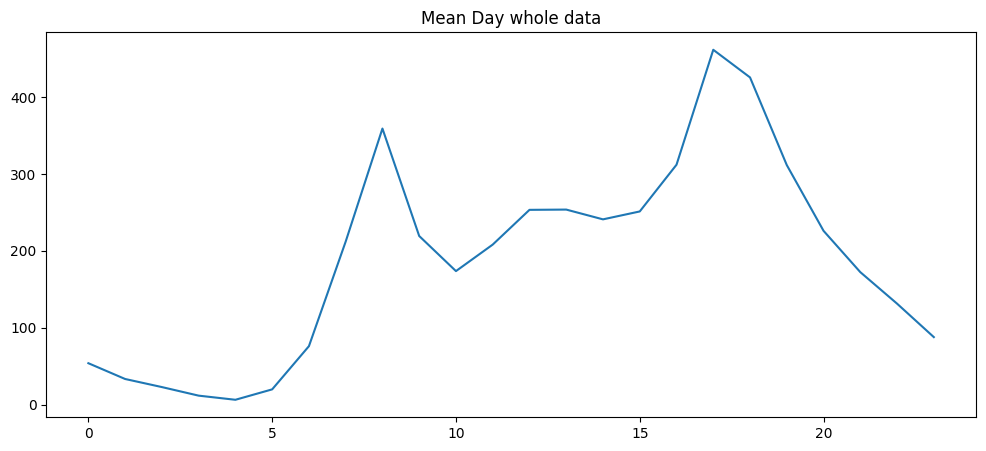

In [39]:
plt.figure(figsize=(12,5))
plt.title("Mean Day whole data")
plt.plot(target_h)

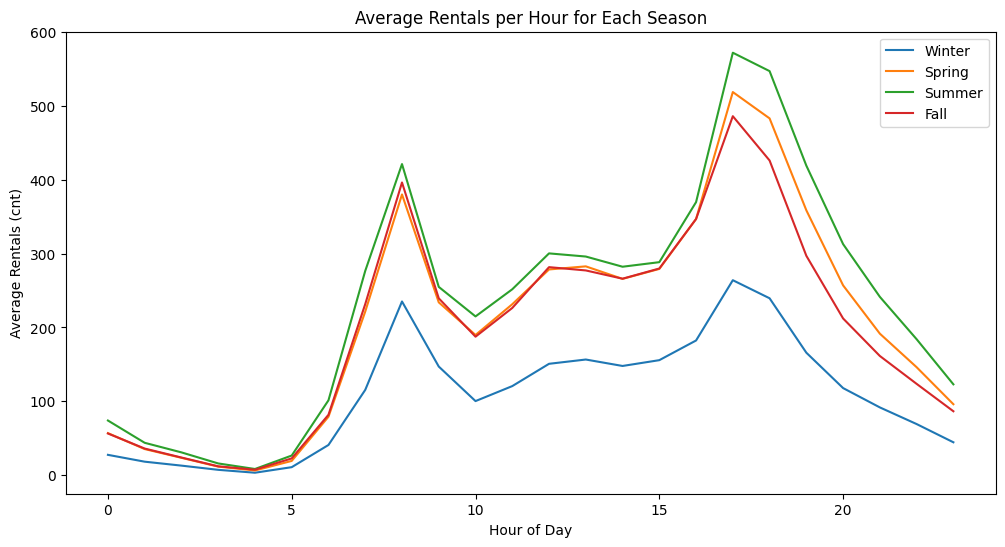

In [37]:
# Plot: Normal day per season (average rentals by hour in each season)
plt.figure(figsize=(12,6))
for season in df['season'].unique():
    avg_per_hour = df[df['season'] == season].groupby('hr')['cnt'].mean()
    plt.plot(avg_per_hour.index, avg_per_hour.values, label=season.capitalize())
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals (cnt)')
plt.title('Average Rentals per Hour for Each Season')
plt.legend()
plt.show()

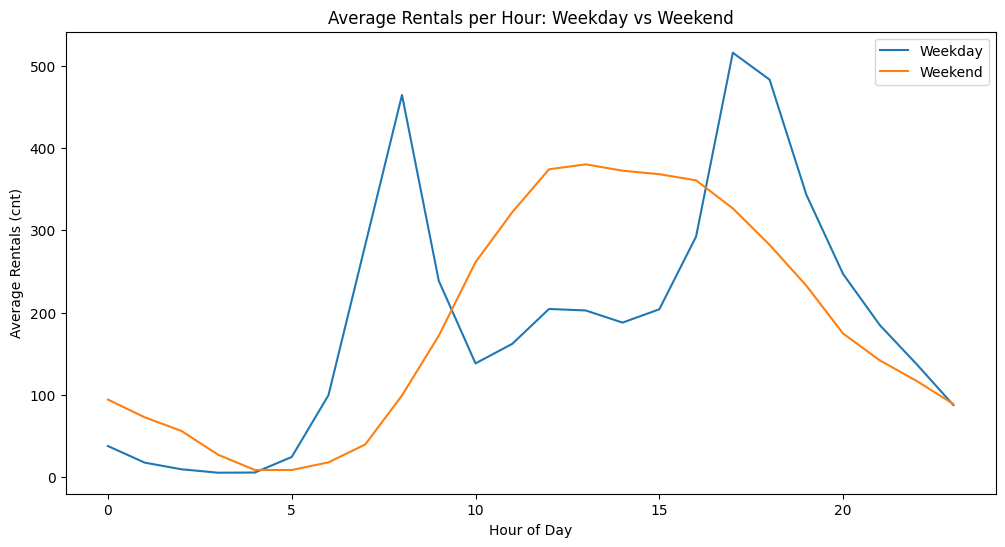

In [38]:
# Plot: Normal day by weekday/weekend (average rentals by hour, weekday vs weekend)
plt.figure(figsize=(12,6))
df['is_weekend'] = df['weekday'].apply(lambda wd: 'Weekend' if wd in [0,6] else 'Weekday')
for grp in ['Weekday', 'Weekend']:
    avg_per_hour = df[df['is_weekend'] == grp].groupby('hr')['cnt'].mean()
    plt.plot(avg_per_hour.index, avg_per_hour.values, label=grp)
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals (cnt)')
plt.title('Average Rentals per Hour: Weekday vs Weekend')
plt.legend()
plt.show()

- Normal spike over before(7/8)/after work (18/19), a bit over lunch, zero at night more or less
- Cyclical, seasonal behaviour

### Rentals by Season

In [17]:
# Define mapping
season_map = {
    1: "winter",
    2: "spring",
    3: "summer",
    4: "fall"
}

df["season"] = df["season"].apply(lambda x: season_map.get(x, "unknown"))

In [19]:
season_stats = df.groupby("season")["cnt"].agg(["mean", "median", "count"])
season_stats

mean  median  count
season                           
fall    198.868856   155.5   4232
spring  208.344069   165.0   4409
summer  236.016237   199.0   4496
winter  111.114569    76.0   4242

### Rental by Weather

In [ ]:
weather_map = {
    1: "clear",
    2: "mist/cloudy",
    3: "light rain/show",
    4: "heavy rain/snow"
}

df["weathersit"] = df["weathersit"].map(weather_map)

In [21]:
order = ["clear", "mist/cloudy", "light rain/show", "heavy rain/snow"]
weather_mean = df.groupby("weathersit")["cnt"].mean().reindex(order)

Text(0.5, 0, 'Weather Situation')

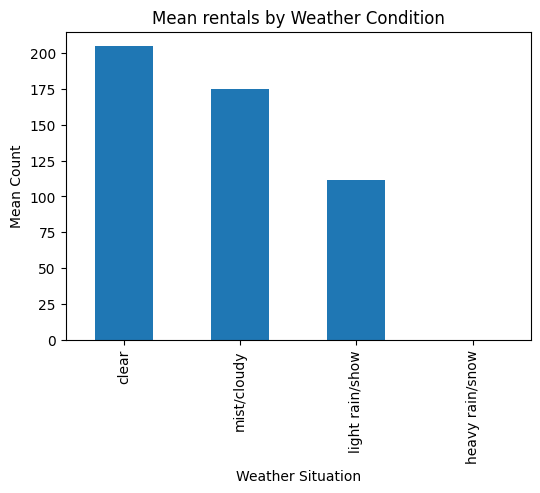

In [22]:
plt.figure(figsize=(6,4))
weather_mean.plot(kind="bar")
plt.title("Mean rentals by Weather Condition")
plt.ylabel("Mean Count")
plt.xlabel("Weather Situation")

### Rentals by Weekday

In [23]:
weekday_map = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

df["weekday_name"] = df["weekday"].map(weekday_map)

In [24]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_mean = df.groupby("weekday_name")["cnt"].mean().reindex(order)

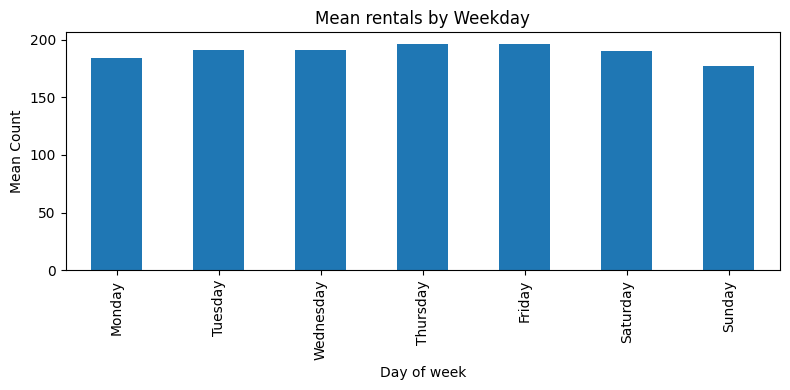

In [25]:
plt.figure(figsize=(8,4))
weekday_mean.plot(kind="bar")
plt.title("Mean rentals by Weekday")
plt.ylabel("Mean Count")
plt.xlabel("Day of week")
plt.tight_layout()

In [26]:
# 1) Map holiday flag to human labels
holiday_map = {
    0: "Non-holiday",
    1: "Holiday"
}
df["holiday_name"] = df["holiday"].map(holiday_map)

In [27]:
# 2) Compute mean rentals by holiday status
order = ["Non-holiday", "Holiday"]
holiday_mean = df.groupby("holiday_name")["cnt"].mean().reindex(order)

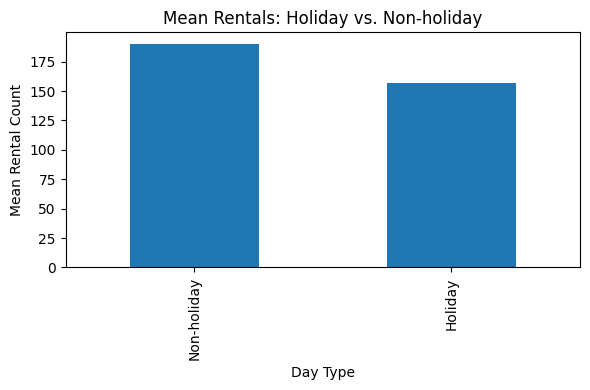

In [28]:
# 3) Plot
plt.figure(figsize=(6, 4))
holiday_mean.plot(kind="bar")
plt.title("Mean Rentals: Holiday vs. Non-holiday")
plt.xlabel("Day Type")
plt.ylabel("Mean Rental Count")
plt.tight_layout()

### Rental by working days

In [30]:
# 1) Map workingday flag to names
working_map = {
    0: "Non-working day",
    1: "Working day"
}
df["workingday_name"] = df["workingday"].map(working_map)

In [31]:
# 2) Compute mean rentals by working day status
order = ["Non-working day", "Working day"]
working_mean = df.groupby("workingday_name")["cnt"].mean().reindex(order)

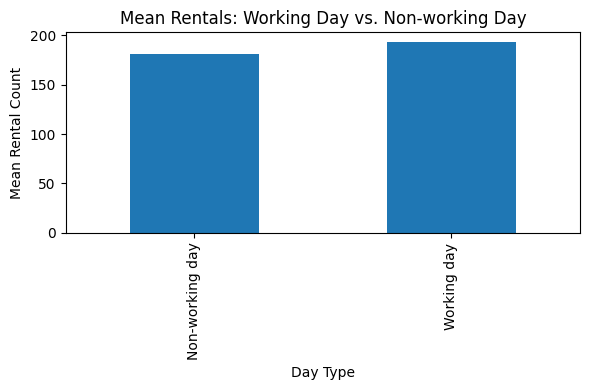

In [32]:
# 3) Plot
plt.figure(figsize=(6, 4))
working_mean.plot(kind="bar")
plt.title("Mean Rentals: Working Day vs. Non-working Day")
plt.xlabel("Day Type")
plt.ylabel("Mean Rental Count")
plt.tight_layout()

### Rental vs temperature

<Axes: xlabel='temp', ylabel='cnt'>

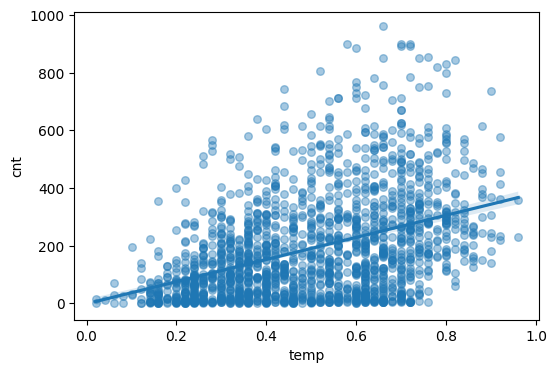

In [ ]:
n = 10 # we cna plot n-th point for better visibilty
plt.figure(figsize=(6, 4))
sns.regplot(x=df['temp'][::n], y=df['cnt'][::n], scatter_kws={'alpha': 0.4, 's': 30}) # show regression as well to understand the data better

### Rental vs humidity

<Axes: xlabel='hum', ylabel='cnt'>

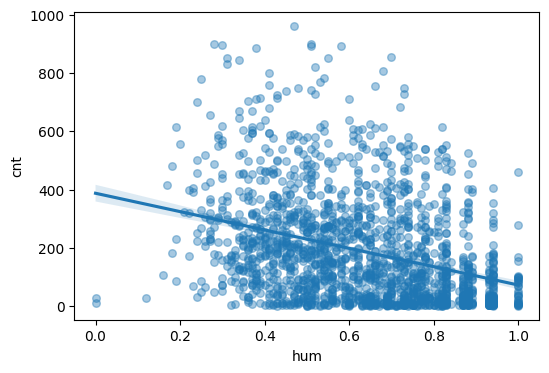

In [34]:
n = 10 # we cna plot n-th point for better visibilty
plt.figure(figsize=(6, 4))
sns.regplot(x=df['hum'][::n], y=df['cnt'][::n], scatter_kws={'alpha': 0.4, 's': 30})

### Rental vs windspeed

<Axes: xlabel='windspeed', ylabel='cnt'>

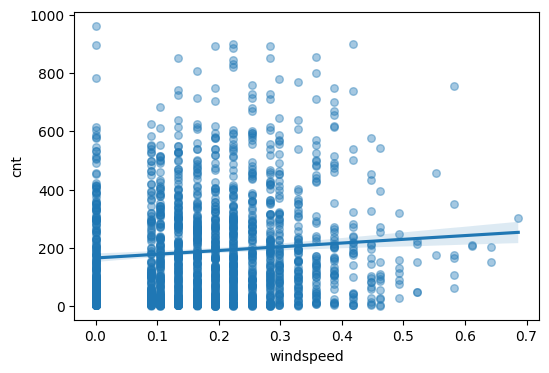

In [35]:
n = 10 # we cna plot n-th point for better visibilty
plt.figure(figsize=(6, 4))
sns.regplot(x=df['windspeed'][::n], y=df['cnt'][::n], scatter_kws={'alpha': 0.4, 's': 30})

## Analysis Conclusions

**Seasonality Effects**
- Mean rentals are lowest in Winter and highest in Summer and Spring.
- Fall has moderate rentals, suggesting weather strongly impacts usage.

**Weather Conditions**
- Rentals drop sharply as weather worsens.
- Clear weather has the highest rentals.
- Mist or cloudy conditions slightly reduce rentals.
- Light snow/rain causes a large drop.
- Heavy rain/snow leads to very low rentals.

**Weekday Patterns**
- Rentals are relatively uniform across all weekdays, with a slight drop on Sunday.
- Weekdays seems people use it for going to work (peak before and after work), weekends people use it more for leisure (peak from before lunch to early afternoon)
- Indicates no strong day-of-week effect, possibly due to consistent commuter behavior.

**Holidays vs Non-Holidays**
- Non-holidays have slightly more rentals than holidays.
- Suggests people use bikes more for commuting than for recreation.


**Temperature vs Rentals**
- Positive correlation: Higher temperatures are associated with more rentals.
- Indicates people prefer biking in warmer weather.
- We also see that there are a lot of zero rentals across the entire temperature range. This might be a challenge in terms of building a model

**Humidity vs Rentals**
- Negative trend: As humidity increases, rentals decrease.
- High humidity may discourage outdoor activity.
- Similar to temperature, many rentals are zero across a wide humidity range.

**Windspeed vs Rentals**
- Slight negative correlation: Higher windspeed slightly reduces rentals.
- But the effect is less pronounced than temperature or humidity.
- We also see that windspeed has a clear descrite behavior and overall does not seem to be a good feature for the model.

**Overall Conclusions**
- The target has a strong seasonal behavior, especially daily.
- Strong predictors: hour, temp, season, weather, workingday – clear patterns with rentals.
- Moderate predictors: humidity (weak negative trend), weekday (slight variation).
- Weak predictor: windspeed – little impact on rentals.

## Possible Further Analysis

- Look into the cross of Temperature & Humidity against rentals 
- Look into high Temperatures, reduce cnt? 
- 